In [1]:
import os
import sys
import gzip
import gpxpy
import shutil
import fitdecode
import gpxpy.gpx
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import parse_fit
import parse_gpx
import parse_tcx

pd.options.display.max_columns = 100

%load_ext autoreload
%autoreload 2

In [2]:
list_of_fit_files = ["\\".join((".\\data", v)) for v in os.listdir(".\\data")
                     if ".gpx" not in v and ".gz" not in v]
list_of_gpx_files = ["\\".join((".\\data", v)) for v in os.listdir(".\\data")
                     if ".gpx" in v]

In [3]:
# SAVE FILES TO AVOID RECOMPUTING EACH TIME
fit_file_laps = pd.read_parquet(".\\data\\fit_file_laps.parquet")
fit_file_points = pd.read_parquet(".\\data\\fit_file_points.parquet")

In [3]:
def compute_power(weight, bike_wgt, speed, slope):
    
    # 1) rolling resistance
    C_rr = np.random.uniform(0.0025, 0.005) # coefficient of rolling resistance
    m = weight + bike_wgt # total mass
    g = 9.81

    P_rr = C_rr * m * speed * g

    # 2) Aerodynamic drag
    rho = 1.225 # air density
    C_d = 0.88 # drag coefficient
    A = 0.5 # frontal area

    P_aero = 0.5 * rho * C_d * A * np.power(speed, 3)

    # 3) Gradient resistance
    slope_rad = slope * (np.pi/180)
    P_gr = m * g * speed * np.sin(slope_rad)

    eta = 0.95 # drivetrain efficiency

    P = (P_rr + P_aero + P_gr) / eta

    return max(P, 0)

1. Prendi attività Zwift:
     * y = errore (power_stimata, power_reale)
     * power_stimata con grade = 0
     * X = pesi, speed, cadence, grade
     * Come cambia l'errore in base a X
2. Prendi i coefficienti ottenuti in (1) con attività Garmin
    * y = power_stimata + $\alpha\cdot$ speed + $\beta\cdot$ HR
    * ricalcola errore rispetto a potenza media da Strava

In [18]:
_, dr = parse_fit.get_dataframes(".\\data\\DR\\16438299806_ACTIVITY.fit")

In [59]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error



Xy = dr[["altitude", "cadence", "enhanced_speed", "current_slope", "heart_rate", "power"]].copy()
Xy["heart_rate"] = Xy["heart_rate"].bfill()
Xy["current_slope"] = Xy["current_slope"].fillna(0)
Xy.loc[(Xy["cadence"].isnull()) & (Xy["enhanced_speed"] == 0), "cadence"] = 0
Xy["power"] = Xy["power"].fillna(0)

# Xy["cadence"] = Xy["cadence"].fillna(int(Xy["cadence"].mean()))
# Xy["athlete_weight"] = 85.5
# Xy["bike_weight"] = 8.8

Xy = Xy.dropna(how = "any").reset_index(drop = True)

Xy["estimated_power"] = Xy.apply(lambda row: compute_power(weight = 85.5, bike_wgt = 8.8,
                                                           speed = row["enhanced_speed"],
                                                           slope = row["current_slope"]),
                                 axis = 1)

X = Xy.drop("power", axis = 1)
y = Xy["power"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True)


linreg = LinearRegression()

linreg.fit(X_train, y_train)

LinearRegression()

In [60]:
def ReLU(x):
    return x * (x > 0)

In [61]:
# Performance on training
print("R^2: {:.2f}".format(r2_score(y_train, ReLU(linreg.predict(X_train)))))
print("RMSE: {:.2f}".format(root_mean_squared_error(y_train, ReLU(linreg.predict(X_train)))))
print("MAE: {:.2f}".format(mean_absolute_error(y_train, ReLU(linreg.predict(X_train)))))
print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_train, ReLU(linreg.predict(X_train)))))
print()
# Performance on test
print("R^2: {:.2f}".format(r2_score(y_test, ReLU(linreg.predict(X_test)))))
print("RMSE: {:.2f}".format(root_mean_squared_error(y_test, ReLU(linreg.predict(X_test)))))
print("MAE: {:.2f}".format(mean_absolute_error(y_test, ReLU(linreg.predict(X_test)))))
print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, ReLU(linreg.predict(X_test)))))

R^2: 0.65
RMSE: 63.28
MAE: 42.81
MAPE: 3048137033792106496.00 %

R^2: 0.66
RMSE: 62.76
MAE: 42.35
MAPE: 3070695020335926272.00 %


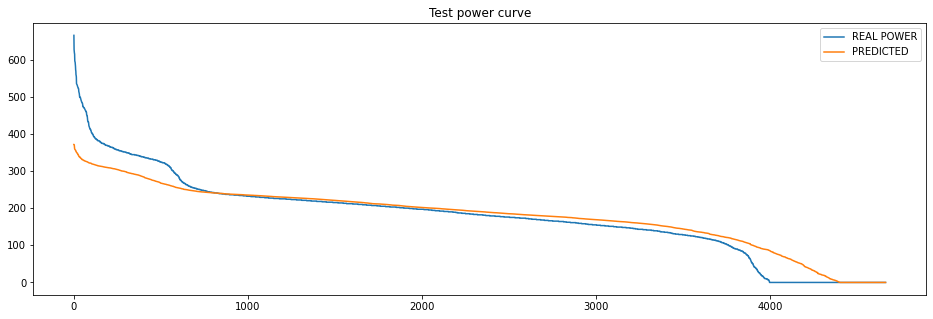

In [67]:
plt.figure(figsize = (16, 5))
plt.plot(sorted(y_test)[::-1], label = "REAL POWER")
plt.plot(sorted(ReLU(linreg.predict(X_test)))[::-1], label = "PREDICTED")
plt.title("Test power curve")
plt.legend()
plt.show()